In [19]:
import sys
sys.path.append('.')
import random
from blackjack import BlackJack
import matplotlib.pyplot as plt
import numpy as np


In [ ]:

def policy1(state):
    return 0 if state[0] < 20 else 1
env = BlackJack()
def get_episode(env,policy):
    episode = []
    state = env.reset()
    done = False
    while not done:
        action = policy(state)
        next_state, reward, done = env.step(action)
        episode.append((state, action, reward))
        state = next_state
    return episode
from collections import defaultdict
returns = defaultdict(list)
V = defaultdict(float)
env = BlackJack()
EPISODES = 10_000
for _ in range(EPISODES):
    episode = get_episode(env,policy1)
    G = 0
    visited = set()
    returns_here = [0]*len(episode)
    for t in reversed(range(len(episode))):
        _, _, reward = episode[t]
        G += reward
        returns_here[t] = G
    visited = set()
    for t, (state, action, _) in enumerate(episode):
        if state not in visited:
            returns[state].append(returns_here[t])
            V[state] = sum(returns[state]) / len(returns[state])
            visited.add(state)  
print("V(PlayerSum=21):", V[(21, 10, False)])
print("V(PlayerSum=5):", V[(5, 10, False)])


V(PlayerSum=21): 0.819672131147541
V(PlayerSum=5): -0.5714285714285714


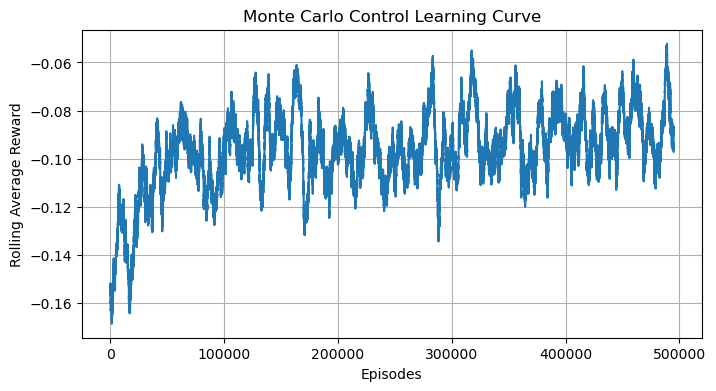

In [34]:
EPISODES = 500_000
Q = defaultdict(lambda : [0.0,0.0])
ALPHA = 0.01
EPSILON = 0.1
def ep_greedy(state,eps =0.1):
    if random.random() < eps:
        return random.choice([0,1])
    return 0 if Q[state][0] > Q[state][1] else 1
EPISODE_REWARDS = []
for _ in range(EPISODES):
    episode = get_episode(env,ep_greedy)
    G = 0
    Gt = [0]*len(episode)

    for t in reversed(range(len(episode))):
        _, _, reward = episode[t]
        G += reward
        Gt[t] = G
    EPISODE_REWARDS.append(G)
    visited = set()
    for t, (state, action, _) in enumerate(episode):
        if (state, action) not in visited:
            Q[state][action] += ALPHA * (Gt[t] - Q[state][action])
            visited.add((state, action))
    EPSILON = max(0.01,1.0-EPSILON/200_000)

WINDOW = 5000
rolling_avg = np.convolve(
    EPISODE_REWARDS,
    np.ones(WINDOW)/WINDOW,
    mode="valid"
)

plt.figure(figsize=(8,4))
plt.plot(rolling_avg)
plt.xlabel("Episodes")
plt.ylabel("Rolling Average Reward")
plt.title("Monte Carlo Control Learning Curve")
plt.grid(True)
plt.show()



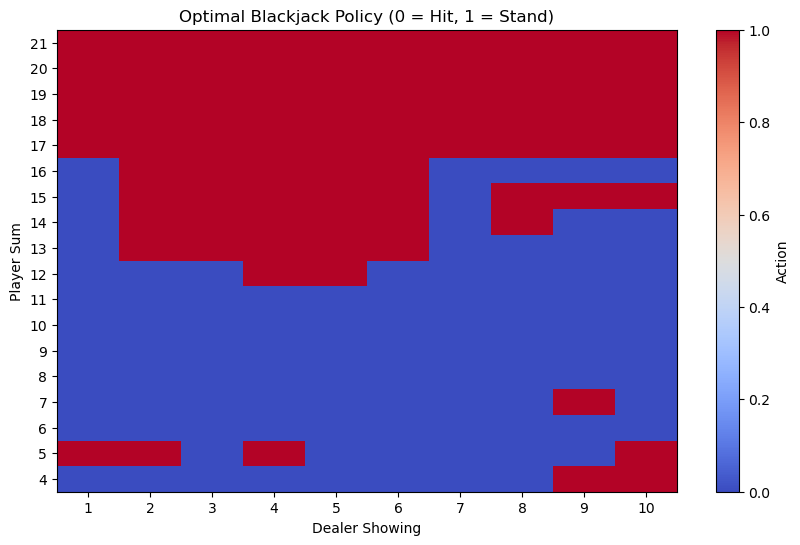

In [33]:
player_sums = list(range(4, 22))
dealer_cards = list(range(1, 11)) 

policy = np.zeros((len(player_sums), len(dealer_cards)))

for i, ps in enumerate(player_sums):
    for j, dc in enumerate(dealer_cards):
        state = (ps, dc, False)
        policy[i, j] = 0 if Q[state][0] > Q[state][1] else 1

plt.figure(figsize=(10, 6))
plt.imshow(policy, origin="lower", aspect="auto", cmap="coolwarm")

plt.xticks(range(len(dealer_cards)), dealer_cards)
plt.yticks(range(len(player_sums)), player_sums)

plt.xlabel("Dealer Showing")
plt.ylabel("Player Sum")
plt.title("Optimal Blackjack Policy (0 = Hit, 1 = Stand)")

plt.colorbar(label="Action")
plt.show()

